In [74]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

from os.path import exists

import gdown
import zipfile

from datetime import datetime

### Data Loading

In [4]:
# Plot a specified column of the dataframe for a specific battery_id
def plot_battery_param(battery_id, column, df):
    x = df.loc[df["battery_id"] == battery_id].index
    y = df[column].loc[df["battery_id"] == battery_id]
    plt.plot(x, y)
    plt.xlabel('datapoint')
    plt.ylabel(column)
    plt.title('battery_id = %s'%battery_id)

In [5]:
# For any specific battery (battery_id) calculate a statistic (such as mean, max, min) of a parameter (such as 'temperature') at 10 SoC bins.
from scipy.stats import binned_statistic
def binned_by_SoC (battery_id, param, df, statistic = 'mean'):
    x = df["state_of_charge_percent"].loc[df["battery_id"]==battery_id] # Data to be binned
    values = df[param].loc[df["battery_id"]==battery_id] # Data on which the statistic is computed
    binned_values, bin_edges, _ = binned_statistic(x, values, statistic = statistic, bins=[0,10,20,30,40,50,60,70,80,90,100])
    return binned_values, bin_edges

#### Data Frame Columns

 `current_out`: current withdrawn from the box by the consumer <br>
 `current_in`: current supplied to the box from the solar panel <br>
 `current`: `current_out` - `current-in` --> net current that goes in or out of the battery <br>
 `temperature`: temperature in deg C <br>
 `timestamp`: YYYY-MM-DD HH:MM:SS <br>
 `panel_voltage`: voltage of the battery in V <br>
 `state_of_charge_percent`: state of charge of the battery in percent <br>
 `battery_id`: unique identifier of the battery <br>

In [6]:
# Load times series csv file
# Each file contains data from approximately 50 devices
ts1_df = pd.read_csv('..\data/devices1.csv')
ts2_df = pd.read_csv('..\data/devices2.csv')
ts3_df = pd.read_csv('..\data/devices3.csv')
ts4_df = pd.read_csv('..\data/devices4.csv')
ts_df = pd.concat([ts1_df, ts2_df, ts3_df, ts4_df], axis = 0, ignore_index = True) # Complete dataframe

In [7]:
#View slices of the complete dataframe ts_df
ts_df.iloc[:10]

,battery_voltage,current,current_in,current_out,panel_voltage,state_of_charge_percent,temperature,timestamp,usb_current,voltage,battery_id
0,7.090,-2.542,2.544,0.002,7.240,NaN,NaN,2021-03-02 06:33:24,0.002,7.185,0
1,7.100,-2.548,2.550,0.002,7.245,NaN,NaN,2021-03-02 06:35:24,0.002,7.190,0
2,7.095,-2.472,2.474,0.002,7.275,NaN,NaN,2021-03-02 06:37:24,0.002,7.215,0
3,7.070,-2.232,2.236,0.004,7.370,NaN,NaN,2021-03-02 06:39:24,0.002,7.290,0
4,7.075,-2.276,2.278,0.002,7.350,100.0,28.287938,2021-03-02 06:41:24,0.002,7.280,0
5,7.075,-2.260,2.262,0.002,7.360,NaN,NaN,2021-03-02 06:43:24,0.002,7.285,0
6,6.955,-1.244,1.256,0.012,6.085,NaN,NaN,2021-03-02 06:45:24,0.002,7.230,0
7,6.740,0.004,0.002,0.006,0.005,NaN,NaN,2021-03-02 06:47:24,0.002,6.750,0
8,6.725,0.002,0.002,0.004,0.005,NaN,NaN,2021-03-02 06:49:24,0.002,6.740,0
9,6.720,0.000,0.002,0.002,0.005,102.0,27.152667,2021-03-02 06:51:24,0.002,6.735,0


In [8]:
ts_df.loc[ts_df["battery_id"]==0].loc[:1000,:]

,battery_voltage,current,current_in,current_out,panel_voltage,state_of_charge_percent,temperature,timestamp,usb_current,voltage,battery_id
0,7.090,-2.542,2.544,0.002,7.240,NaN,NaN,2021-03-02 06:33:24,0.002,7.185,0
1,7.100,-2.548,2.550,0.002,7.245,NaN,NaN,2021-03-02 06:35:24,0.002,7.190,0
2,7.095,-2.472,2.474,0.002,7.275,NaN,NaN,2021-03-02 06:37:24,0.002,7.215,0
3,7.070,-2.232,2.236,0.004,7.370,NaN,NaN,2021-03-02 06:39:24,0.002,7.290,0
4,7.075,-2.276,2.278,0.002,7.350,100.0,28.287938,2021-03-02 06:41:24,0.002,7.280,0
...,...,...,...,...,...,...,...,...,...,...,...
996,6.675,-0.192,0.200,0.008,6.680,NaN,NaN,2021-03-03 15:22:55,0.002,6.695,0
997,6.675,-0.182,0.190,0.008,6.675,54.0,24.479286,2021-03-03 15:23:52,0.002,6.695,0
998,6.675,-0.174,0.182,0.008,6.675,NaN,NaN,2021-03-03 15:25:46,0.002,6.695,0
999,6.670,-0.162,0.170,0.008,6.670,NaN,NaN,2021-03-03 15:27:46,0.002,6.690,0


In [9]:
# Examination - print some parameters.
print('ts_df.shape: ', ts_df.shape)
print('max_voltage: ', ts_df["battery_voltage"].max())
print('min_voltage: ', ts_df["battery_voltage"].min())
# Note that the convention here is that charging currents are negative.
print('max charging current: ', ts_df["current"].loc[ts_df["current"] < 0].min())
print('min charging current: ', ts_df["current"].loc[ts_df["current"] < 0].max())
print('max discharging current: ', ts_df["current"].loc[ts_df["current"] >= 0].max())
print('min discharging current: ', ts_df["current"].loc[ts_df["current"] >= 0].min())

ts_df.shape:  (20890508, 11)
max_voltage:  8.215
min_voltage:  4.735
max charging current:  -3.168
min charging current:  -0.0019999999999997
max discharging current:  2.6180000000000003
min discharging current:  0.0


Downsample the ts_df dataframe by removing rows that contain NaN values.

In [10]:
ts_df_lean = ts_df.dropna()

In [11]:
print('Shape of initial dataframe ts_df: ', ts_df.shape)
print('Shape of initial dataframe ts_df_lean: ', ts_df_lean.shape)

Shape of initial dataframe ts_df:  (20890508, 11)
Shape of initial dataframe ts_df_lean:  (4505554, 11)


Add power column and abs(power) column

In [111]:
ts_df_lean["power"] = ts_df_lean["battery_voltage"]*ts_df_lean["current"]
ts_df_lean["abs(power)"] = ts_df_lean["power"].abs()


In [12]:
# convert timestamp column to datetime format. It has useful functionality, such as getting the 'month' or 'year'
ts_df_lean["timestamp"] = pd.to_datetime(ts_df_lean["timestamp"])

<ipython-input-12-e97d88c653ed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_df_lean["timestamp"] = pd.to_datetime(ts_df_lean["timestamp"])


In [29]:
#Add year, and month as dataframe columns
year = np.empty((len(ts_df_lean)), dtype=int)
month = np.empty((len(ts_df_lean)), dtype=int)
for i in range(len(ts_df_lean)):
    year[i] = ts_df_lean["timestamp"].iloc[i].year
    month[i] = ts_df_lean["timestamp"].iloc[i].month

In [30]:
ts_df_lean["year"] = year
ts_df_lean["month"] = month

<ipython-input-30-a7710c5d29c8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_df_lean["year"] = year
<ipython-input-30-a7710c5d29c8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_df_lean["month"] = month


In [31]:
ts_df_lean.head()

,battery_voltage,current,current_in,current_out,panel_voltage,state_of_charge_percent,temperature,timestamp,usb_current,voltage,battery_id,time_battery_sec,dt_sec,year,month
4,7.075,-2.276,2.278,0.002,7.350,100.0,28.287938,2021-03-02 06:41:24,0.002,7.280,0,0.0,600.0,2021,3
9,6.720,0.000,0.002,0.002,0.005,102.0,27.152667,2021-03-02 06:51:24,0.002,6.735,0,600.0,600.0,2021,3
14,6.710,0.010,0.002,0.012,0.005,102.0,26.919203,2021-03-02 07:01:24,0.002,6.725,0,1200.0,600.0,2021,3
19,6.705,0.010,0.002,0.012,0.005,102.0,27.003891,2021-03-02 07:11:24,0.002,6.720,0,1800.0,600.0,2021,3
24,6.705,0.010,0.002,0.012,0.005,102.0,27.017624,2021-03-02 07:21:24,0.002,6.715,0,2400.0,57.0,2021,3


Create two new time-related columns and add them to the dataframe.<br>
Column 'time_battery_seconds' contains values which start at 0 for every battery, subsequently counting the operating time of the battery in seconds. <br>
Column 'dt' gives the sampling time step. Will be useful later to calculate time-weighted averages. At the first row of every battery, dt is zero.

In [14]:
# Had to make some conversions back to string to get this to work.
# Some complications were due to numpy changing the format of datetime objects before storing them.
time_battery_sec = np.empty((0,1))
dt_sec = np.empty((0,1))
for battery in range(0,200):
    single_battery_df = ts_df_lean.loc[ts_df_lean['battery_id']==battery]
    # Get the starting timestamp of this battery. This will be time zero.
    # Also place in this more convenient datetime format which will allow subtraction of datetimes.
    datetime_0 = datetime.strptime(str(single_battery_df["timestamp"].iloc[0]), "%Y-%m-%d %H:%M:%S")
    # Initialise numpy array to store battery_time. Loops using pandas would be too slow.
    battery_time = single_battery_df["timestamp"].astype(str).to_numpy()
    for i, entry in enumerate(battery_time):
        datetime_1 = datetime.strptime(str(entry), "%Y-%m-%d %H:%M:%S")
        battery_time[i] = float((datetime_1-datetime_0).total_seconds())
    # Convert to float:
    battery_time = battery_time.astype(float)
    battery_dt = np.zeros((battery_time.shape[0],)) #Useful mostly because it puts a zero at the -1 index for this battery_id.
    battery_dt[0:-1] = battery_time[1:] - battery_time[0:-1]
    time_battery_sec = np.append(time_battery_sec, battery_time)
    dt_sec = np.append(dt_sec, battery_dt)

In [ ]:
#Sanity check of dimensions:
print('ts_df_lean.shape: ', ts_df_lean.shape)
print('time_battery_seconds.shape: ', time_battery_sec.shape)
print('dt.shape: ', dt_sec.shape)

In [16]:
# Add new pandas Series to ts_df_lean
ts_df_lean["time_battery_sec"] = time_battery_sec
ts_df_lean["dt_sec"] = dt_sec

C:\Users\egaliounas\Anaconda3\envs\BatteryDevBBoxx\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\egaliounas\Anaconda3\envs\BatteryDevBBoxx\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
ts_df_lean.loc[(ts_df_lean["battery_id"]==0) & (ts_df_lean["state_of_charge_percent"].between(30,31))]

In [59]:
bin_edges = list(range(0,160,10))

In [70]:
bin_edges

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]

In [105]:
def binning(battery_id, df, bin_edges, param, statistic = 'mean', month = None):
    filter = (df["battery_id"]==battery_id)
    if month != None:
        filter = filter & (df["month"]==month)
    local_df = df.loc[filter]
    output = np.empty(len(bin_edges)-1)
    output[:] = np.NaN
    for i, edge1 in enumerate(bin_edges[:-1]):
        edge2 = bin_edges[i+1]
        bin_filter = df["state_of_charge_percent"].between(edge1, edge2, inclusive = 'left')
        bin_df = local_df.loc[bin_filter]        
        if statistic == 'max':
            calc = bin_df[param].max()
        elif statistic == 'min':
            calc = bin_df[param].min()
        elif statistic == 'mean':
            #In this case get a weighter average.
            sum_of_bin_dts = bin_df["dt_sec"].sum()
            time_weighted_bin_param = bin_df[param] * bin_df["dt_sec"]
            sum_of_time_weighted_bin_param = time_weighted_bin_param.sum()
            if sum_of_bin_dts == 0:
                calc = np.NaN
            else:
                calc = sum_of_time_weighted_bin_param / sum_of_bin_dts
        output[i]=calc
    return(output)

Create temperature features

In [127]:
#Columns 0-14 will contain the means values
#Columns 15-29 will contain the means values
#Columns 30-44 will contain the means values
temp_features = np.empty((200,45))
temp_features[:] = np.NaN
for battery in range(200):
    calc = binning(battery, ts_df_lean, bin_edges, param='temperature', statistic = 'mean')
    temp_features[battery,0:15] = calc
    calc = binning(battery, ts_df_lean, bin_edges, param='temperature', statistic = 'max')
    temp_features[battery,15:30] = calc
    calc = binning(battery, ts_df_lean, bin_edges, param='temperature', statistic = 'min')
    temp_features[battery,30:45] = calc

In [129]:
temp_features.shape

(200, 45)

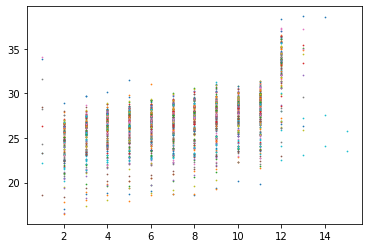

In [132]:
bin_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
f, ax = plt.subplots()
s=0.5
for battery in range(200):
    ax.scatter(bin_list, temp_features[battery,0:15], s=s)

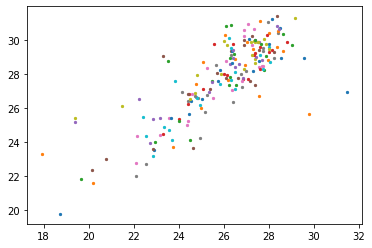

In [138]:
f, ax = plt.subplots()
s=5
for battery in range(200):
    x = temp_features[battery,4]
    y = temp_features[battery,10]
    ax.scatter(x,y, s=s)

In [106]:
binning(150, ts_df_lean, bin_edges, 'temperature', month=3)

array([        nan,         nan,         nan,         nan,         nan,
               nan, 22.6122005 , 23.18400095, 23.87670193, 27.2616697 ,
       27.19380304,         nan,         nan,         nan,         nan])

In [109]:
binning(150, ts_df_lean, bin_edges, param = 'temperature', statistic = 'min')

array([        nan,         nan,         nan,         nan, 30.59739071,
       22.53833829, 20.96360723, 21.13756008, 21.08491646, 22.0531014 ,
       23.64385443, 38.0842298 , 38.50995651, 38.59464408,         nan])

In [112]:
ts_df_lean

,battery_voltage,current,current_in,current_out,panel_voltage,state_of_charge_percent,temperature,timestamp,usb_current,voltage,battery_id,time_battery_sec,dt_sec,year,month,power,abs(power)
4,7.075,-2.276,2.278,0.002,7.350,100.0,28.287938,2021-03-02 06:41:24,0.002,7.280,0,0.0,600.0,2021,3,-16.10270,16.10270
9,6.720,0.000,0.002,0.002,0.005,102.0,27.152667,2021-03-02 06:51:24,0.002,6.735,0,600.0,600.0,2021,3,0.00000,0.00000
14,6.710,0.010,0.002,0.012,0.005,102.0,26.919203,2021-03-02 07:01:24,0.002,6.725,0,1200.0,600.0,2021,3,0.06710,0.06710
19,6.705,0.010,0.002,0.012,0.005,102.0,27.003891,2021-03-02 07:11:24,0.002,6.720,0,1800.0,600.0,2021,3,0.06705,0.06705
24,6.705,0.010,0.002,0.012,0.005,102.0,27.017624,2021-03-02 07:21:24,0.002,6.715,0,2400.0,57.0,2021,3,0.06705,0.06705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20890488,6.715,-0.824,0.832,0.008,6.760,34.0,27.251087,2021-07-05 06:55:38,0.002,6.780,199,15553412.0,600.0,2021,7,-5.53316,5.53316
20890493,6.725,-0.906,0.914,0.008,6.780,35.0,27.386130,2021-07-05 07:05:38,0.002,6.795,199,15554012.0,357.0,2021,7,-6.09285,6.09285
20890496,6.730,-0.954,0.962,0.008,6.790,36.0,27.484550,2021-07-05 07:11:35,0.000,6.800,199,15554369.0,601.0,2021,7,-6.42042,6.42042
20890501,6.740,-1.030,1.038,0.008,6.805,38.0,27.594415,2021-07-05 07:21:36,0.002,6.810,199,15554970.0,600.0,2021,7,-6.94220,6.94220


In [ ]:
ts_df_lean["datetimes"]

In [ ]:
f, ax = plt.subplots()
for cell in range(0,200):
    x = ts_df_lean["battery_id"].loc[ts_df_lean["battery_id"]==cell]
    y = ts_df_lean["dt_sec"].loc[ts_df_lean["battery_id"]==cell]
    ax.scatter(x,y)
ax.set_xlabel('cell id')
ax.set_ylabel('dt')

In [ ]:
f, ax = plt.subplots()
s=0.1
for cell in range(0,200):
    x = ts_df_lean["battery_id"].loc[ts_df_lean["battery_id"]==cell]
    y = ts_df_lean["state_of_charge_percent"].loc[ts_df_lean["battery_id"]==cell]
    ax.scatter(x,y, s=s)
ax.set_xlabel('cell id')
ax.set_ylabel('state_of_charge_percent')

Text(0, 0.5, 'battery_id')

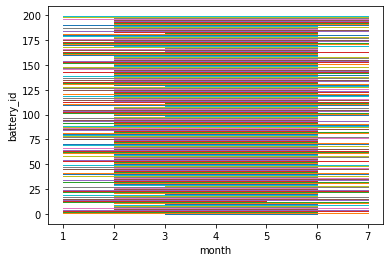

In [41]:
f, ax = plt.subplots()
s=1
for cell in range(0,200):
    cell_min_month = ts_df_lean["month"].loc[ts_df_lean["battery_id"]==cell].min()
    cell_max_month = ts_df_lean["month"].loc[ts_df_lean["battery_id"]==cell].max()
    x = [cell_min_month, cell_max_month]
    y = [cell, cell]
    ax.plot(x,y, linewidth=s)
ax.set_xlabel('month')
ax.set_ylabel('battery_id')

In [ ]:
cell = 1
f, ax = plt.subplots()
x = ts_df_lean["timestamp"].loc[ts_df_lean["battery_id"]==cell].iloc[1:15]
y = ts_df_lean["battery_id"].loc[ts_df_lean["battery_id"]==cell].iloc[1:15]
ax.scatter(x,y)
ax.set_xlabel('time_battery_sec')
ax.set_ylabel('dt_sec')

In [ ]:
cell = 1
f, ax = plt.subplots()
x = ts_df_lean["time_battery_sec"].loc[ts_df_lean["battery_id"]==cell]
y = ts_df_lean["dt_sec"].loc[ts_df_lean["battery_id"]==cell]
ax.scatter(x,y)
ax.set_xlabel('time_battery_sec')
ax.set_ylabel('dt_sec')

In [ ]:
# Extract temperature features at SoC bins. Specifically extract max, min, and mean values.
# Initialise numpy arrays to store the features
temp_features_min = np.empty((200,10))
temp_features_min[:] = np.NaN
temp_features_max = np.empty((200,10))
temp_features_max[:] = np.NaN
temp_features_mean = np.empty((200,10))
temp_features_mean[:] = np.NaN

for battery in range (0,200):
    temp_features_min[battery, :], _ = binned_by_SoC (battery, "temperature", df = ts_df, statistic = 'min')
    temp_features_max[battery, :], _ = binned_by_SoC (battery, "temperature", df = ts_df, statistic = 'max')
    temp_features_mean[battery, :], _ = binned_by_SoC (battery, "temperature", df = ts_df, statistic = 'mean')
# cols = ['battery_id','temp_mean_0to10SoC', 'temp_mean_10to20SoC', 'temp_mean_20to30SoC', 'temp_mean_30to40SoC', 'temp_mean_40to50SoC', 'temp_mean_50to60SoC', 'temp_mean_60to70SoC',
#     'temp_mean_70to80SoC', 'temp_mean_80to90SoC', 'temp_mean_90to100SoC']
# df_features = pd.Dataframe(columns = cols)
# xticks = ['0','10','20','30','40','50','60','70','80','90']
# plt.bar(temp_bin_edges[:-1], temp_bin_means, align = 'edge', width = 9.5)#, tick_label=xticks)

In [ ]:
# Add the temperature features to pandas dataframes for easier visualisation
cols = ['0to10SoC', '10to20SoC', '20to30SoC', '30to40SoC', '40to50SoC', '50to60SoC', '60to70SoC',
        '70to80SoC', '80to90SoC', '90to100SoC']
df_temp_features_min = pd.DataFrame(temp_features_min, columns = cols)
df_temp_features_max = pd.DataFrame(temp_features_max, columns = cols)
df_temp_features_mean = pd.DataFrame(temp_features_mean, columns = cols)

In [ ]:
df_temp_features_mean.iloc[1]

In [ ]:
#Plots SoC-binned bar charge of a given dataframe. Specify param (e.g. Mean Temp) for title
def SoC_binned_bar_chart(battery_id, df, param=''):
    x = df.columns
    height = df.iloc[battery_id]
    f, ax = plt.subplots()
    ax.bar(x, height, align = 'center')
    ax.set_title('battery_id = %s. Plot of %s'%(battery_id, param))
    plt.setp(ax.get_xticklabels(), rotation=30)

In [ ]:
SoC_binned_bar_chart(0, df_temp_features_mean, 'Mean Temp')

In [ ]:
temp_bin_edges = [0,10,20,30,40,50,60,70,80,90]
xticks = ['0','10','20','30','40','50','60','70','80','90']
plt.bar(temp_bin_edges, temp_bin_means, align = 'edge', width = 9.5)#, tick_label=xticks)

In [ ]:
plot_battery_param(0, 'state_of_charge_percent', ts_df)

In [ ]:
plot_battery_param(0, 'temperature', ts_df)

In [ ]:
ts_df.loc[ts_df["battery_id"]==0].loc[:1000,:]

Alternative dt calculations

In [ ]:
# # Not the fastest but works. Putting data in an ndarray to speed up this loop would make sence, but
# # had issues using datetime objects in ndarray.
# #Requires the dataframe "timestamp" entry to be in datetime format.
# np_dt = np.zeros(len(ts_df_lean))
# for i in range(len(ts_df_lean)-1):
#     np_dt[i] = (ts_df_lean["timestamp"].iloc[i+1] - ts_df_lean["timestamp"].iloc[i]).total_seconds()
# #Add dt to the dataframe
# ts_df_lean.loc[:,"dt"] = np_dt

### Plotting

In [ ]:
# Basic plot of the data

xtick_locator = AutoDateLocator()
xtick_formatter = AutoDateFormatter(xtick_locator)

start_pidx = 0 
end_pidx = 6000 

dates = matplotlib.dates.date2num(ts_df.loc[ts_df["battery_id"]==0].loc[start_pidx:end_pidx, "timestamp"])
current = ts_df.loc[ts_df["battery_id"]==0].loc[start_pidx:end_pidx, "current"]
voltage = ts_df.loc[ts_df["battery_id"]==0].loc[start_pidx:end_pidx, "battery_voltage"]

fig, host = plt.subplots()
par1 = host.twinx()

p1, = host.plot(dates, current, 'b', label='Current')
p2, = par1.plot(dates, voltage, 'r', label='Voltage')

host.set_ylabel('Current (A)')
par1.set_ylabel('Voltage (V)')
host.set_xlabel('Date')

host.xaxis.set_major_locator(xtick_locator)
host.xaxis.set_major_formatter(xtick_formatter)
fig.autofmt_xdate()

lines = [p1, p2]
host.legend(lines, [l.get_label() for l in lines], loc=1, bbox_to_anchor=(0.995,0.22))
fig.show()